In [26]:
#Este software foi implementado usando um ambiente Debian 9.9,
#com Python 3 na versão 3.5.3, Pandas 0.19.2, NumPy 1.12.1,
#Scikit-Learn 0.18 e Matplotlib 2.0.0
#Compatibilidade com versões posteriores não é garantida

#carrega as bibliotecas a serem utilizadas

import os
import pandas as pd 
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [27]:
#carrega os arquivos contendo os valores das ações das 50 empresas mais negociadas na Nasdaq
#eles estão armazenados na pasta Nasdaq100list50+

pasta = 'Nasdaq100list50+'

caminhos = [os.path.join(pasta, nome) for nome in os.listdir(pasta)]
arquivos = [arq for arq in caminhos if os.path.isfile(arq)]
csvs = [arq for arq in arquivos if arq.lower().endswith(".csv")]

#abre o arquivo texto que será usado para armazenar as medidas de desempenho dos agrupamentos
arquivo = open("saída.txt","w")

#lê os arquivos csv para um vetor
csvStock = []

for arq in csvs:
    csvStock = pd.read_csv(arq,parse_dates=['timestamp'],index_col='timestamp')
    
print(csvStock)

                        open     high      low    close  volume
timestamp                                                      
2019-06-20 16:00:00  71.7599  71.7600  71.7200  71.7400   58754
2019-06-20 15:59:00  71.7600  71.7800  71.7500  71.7501   18782
2019-06-20 15:58:00  71.7700  71.7800  71.7450  71.7700   20036
2019-06-20 15:57:00  71.7900  71.7900  71.7500  71.7600   16851
2019-06-20 15:56:00  71.8100  71.8400  71.7700  71.7850   30711
2019-06-20 15:55:00  71.7900  71.8050  71.7500  71.8050   17898
2019-06-20 15:54:00  71.7650  71.8000  71.7650  71.7900   10660
2019-06-20 15:53:00  71.8000  71.8100  71.7400  71.7600   13708
2019-06-20 15:52:00  71.8300  71.8300  71.7900  71.8100   11355
2019-06-20 15:51:00  71.8300  71.8300  71.8050  71.8300   12480
2019-06-20 15:50:00  71.8100  71.8300  71.8000  71.8200   11685
2019-06-20 15:49:00  71.7950  71.8500  71.7900  71.8000   18915
2019-06-20 15:48:00  71.7900  71.8200  71.7800  71.7900   14390
2019-06-20 15:47:00  71.8350  71.8350  7

In [28]:
#após a leitura dos arquivos, são removidas as tuplas com dados ausentes e 
#os dados absolutos são transformados em variações percentuais
    
csvStock = csvStock.dropna()

csvStock['Name']     = arq.replace(".csv","")
csvStock['Name']     = csvStock['Name'].astype('category')

csvStock['OpenPct']  = csvStock['open'].pct_change()
csvStock['HighPct']  = csvStock['high'].pct_change()
csvStock['LowPct']   = csvStock['low'].pct_change()
csvStock['ClosePct'] = csvStock['close'].pct_change()

csvStock = csvStock[['OpenPct','HighPct','LowPct','ClosePct','Name']].dropna()

In [29]:
#os dados obtidos dos arquivos csv são transformados em um vetor NumPy

train_data = np.array(csvStock.iloc[:,:-1])
class_data = np.array(csvStock.iloc[:,-1])

#a base de dados é dividida em duas partições
#apesar de serem usados os nomes treinamento e teste, são apenas duas partições quaisquer
#não há distinção entre treino e teste por não ser aprendizado supervisionado
#porém, nós temos conhecimento daquilo que é chamado ground truth

X_train, X_test, y_train, y_test = train_test_split(train_data, class_data, test_size=0.2)

labels_true = np.array(y_train)


In [30]:
#aqui é executado o algoritmo de agrupamento baseado em densidade DBSCAN
#o valor eps=0.003 obteve o melhor resultado conforme visualização gráfica

db = DBSCAN(eps=0.003, min_samples=10).fit(X_train)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [31]:
#abaixo estão algumas medidas obtidas do DBSCAN com os Dados da Partição 1 com Todos os Componentes
#foram utilizadas todas as medidas disponíveis no SciKit Learning para Agrupamento
#exceto a Silheta Amostra a Amostra, por esta retornar um vetor, e não um escalar
#esta parte é aquela que imprime na tela

print('Medidas Obtidas Usando o DBSCAN e Todos os Componentes da Partição 1')
print('Número estimado de grupos: %d' % n_clusters_)
print('Número estimado de outliers: %d' % n_noise_)
print("Homogeneidade: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completude: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-medida: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Índice Rand Ajustado: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print("Informação Mútua Ajustada: %0.3f" % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Informação Mútua Normalizada: %0.3f" % metrics.normalized_mutual_info_score(labels_true, labels))
print("Informação Mútua: %0.3f" % metrics.mutual_info_score(labels_true, labels))
print("Índice Fowlkes-Mallows: %0.3f" % metrics.fowlkes_mallows_score(labels_true, labels))
print("Coeficiente Calinski-Harabaz: %0.3f" % metrics.calinski_harabaz_score(X_train, labels))
print("Coeficiente Silhueta: %0.3f" % metrics.silhouette_score(X_train, labels))

#esta parte são as mesmas medidas e o mesmo algoritmo da parte anterior
#só que a saída é gravada em um arquivo texto em vez de imprimir na tela

arquivo.write('Medidas Obtidas Usando o DBSCAN e Todos os Componentes da Partição 1\n')
arquivo.write('Número estimado de grupos: %d\n' % n_clusters_)
arquivo.write('Número estimado de outliers: %d\n' % n_noise_)
arquivo.write("Homogeneidade: %0.3f\n" % metrics.homogeneity_score(labels_true, labels))
arquivo.write("Completude: %0.3f\n" % metrics.completeness_score(labels_true, labels))
arquivo.write("V-medida: %0.3f\n" % metrics.v_measure_score(labels_true, labels))
arquivo.write("Índice Rand Ajustado: %0.3f\n" % metrics.adjusted_rand_score(labels_true, labels))
arquivo.write("Informação Mútua Ajustada: %0.3f\n" % metrics.adjusted_mutual_info_score(labels_true, labels))
arquivo.write("Informação Mútua Normalizada: %0.3f\n" % metrics.normalized_mutual_info_score(labels_true, labels))
arquivo.write("Informação Mútua: %0.3f\n" % metrics.mutual_info_score(labels_true, labels))
arquivo.write("Índice Fowlkes-Mallows: %0.3f\n" % metrics.fowlkes_mallows_score(labels_true, labels))
arquivo.write("Coeficiente Calinski-Harabaz: %0.3f\n" % metrics.calinski_harabaz_score(X_train, labels))
arquivo.write("Coeficiente Silhueta: %0.3f\n" % metrics.silhouette_score(X_train, labels))

Medidas Obtidas Usando o DBSCAN e Todos os Componentes da Partição 1
Número estimado de grupos: 1
Número estimado de outliers: 3
Homogeneidade: 1.000
Completude: 0.000
V-medida: 0.000
Índice Rand Ajustado: 0.000
Informação Mútua Ajustada: 0.000
Informação Mútua Normalizada: 0.000
Informação Mútua: 0.000
Índice Fowlkes-Mallows: 0.998
Coeficiente Calinski-Harabaz: 57.287
Coeficiente Silhueta: 0.886


28

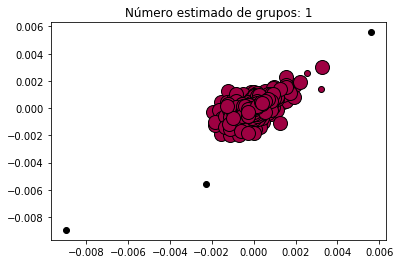

In [32]:
#esta parte gera o gráfico dos grupos obtidos com o DBSCAN
#na melhor configuração, foi obtido um único grupo e 4 outliers

unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_train[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X_train[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Número estimado de grupos: %d' % n_clusters_)
plt.show()



Medidas Obtidas Usando o KMeans de 5 Clusters e os Todos os Componentes da Partição 1
Homogeneidade: 1.000
Completude: -0.000
V-medida: -0.000
Índice Rand Ajustado: 0.000
Informação Mútua Ajustada: -0.000
Informação Mútua Normalizada: -0.000
Informação Mútua: -0.000
Índice Fowlkes-Mallows: 0.578
Coeficiente Calinski-Harabaz: 486.877
Coeficiente Silhueta: 0.234


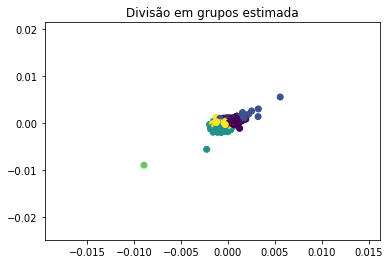

In [33]:
#esta parte é uma comparação com o k-Means
#foi utilizada a configuração com 5 clusters

kmeans = KMeans(n_clusters=5, random_state=0).fit(X_train)
labels = kmeans.labels_

#abaixo estão algumas medidas obtidas do KMeans com 5 Clusters
#foram utilizadas as mesmas medidas do SciKit Learning para Agrupamento do Algoritmo Anterior

print('')
print('Medidas Obtidas Usando o KMeans de 5 Clusters e os Todos os Componentes da Partição 1')
print("Homogeneidade: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completude: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-medida: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Índice Rand Ajustado: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print("Informação Mútua Ajustada: %0.3f" % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Informação Mútua Normalizada: %0.3f" % metrics.normalized_mutual_info_score(labels_true, labels))
print("Informação Mútua: %0.3f" % metrics.mutual_info_score(labels_true, labels))
print("Índice Fowlkes-Mallows: %0.3f" % metrics.fowlkes_mallows_score(labels_true, labels))
print("Coeficiente Calinski-Harabaz: %0.3f" % metrics.calinski_harabaz_score(X_train, labels))
print("Coeficiente Silhueta: %0.3f" % metrics.silhouette_score(X_train, labels))

#esta parte são as mesmas medidas e o mesmo algoritmo da parte anterior
#só que a saída é gravada em um arquivo texto em vez de imprimir na tela

arquivo.write('\n')
arquivo.write('Medidas Obtidas Usando o KMeans de 5 Clusters e Todos os Componentes da Partição 1\n')
arquivo.write("Homogeneidade: %0.3f\n" % metrics.homogeneity_score(labels_true, labels))
arquivo.write("Completude: %0.3f\n" % metrics.completeness_score(labels_true, labels))
arquivo.write("V-medida: %0.3f\n" % metrics.v_measure_score(labels_true, labels))
arquivo.write("Índice Rand Ajustado: %0.3f\n" % metrics.adjusted_rand_score(labels_true, labels))
arquivo.write("Informação Mútua Ajustada: %0.3f\n" % metrics.adjusted_mutual_info_score(labels_true, labels))
arquivo.write("Informação Mútua Normalizada: %0.3f\n" % metrics.normalized_mutual_info_score(labels_true, labels))
arquivo.write("Informação Mútua: %0.3f\n" % metrics.mutual_info_score(labels_true, labels))
arquivo.write("Índice Fowlkes-Mallows: %0.3f\n" % metrics.fowlkes_mallows_score(labels_true, labels))
arquivo.write("Coeficiente Calinski-Harabaz: %0.3f\n" % metrics.calinski_harabaz_score(X_train, labels))
arquivo.write("Coeficiente Silhueta: %0.3f\n" % metrics.silhouette_score(X_train, labels))

plt.scatter(X_train[:, 0], X_train[:, 1], c=labels.astype(np.float))
plt.title("Divisão em grupos estimada")
plt.show()


Medidas Obtidas Usando o KMeans de 8 Clusters e Todos os Componentes da Partição 1
Homogeneidade: 1.000
Completude: -0.000
V-medida: -0.000
Índice Rand Ajustado: 0.000
Informação Mútua Ajustada: -0.000
Informação Mútua Normalizada: -0.000
Informação Mútua: -0.000
Índice Fowlkes-Mallows: 0.504
Coeficiente Calinski-Harabaz: 505.843
Coeficiente Silhueta: 0.271

Medidas Obtidas Usando o KMeans de 3 Clusters e Todos os Componentes da Partição 1
Homogeneidade: 1.000
Completude: -0.000
V-medida: -0.000
Índice Rand Ajustado: 0.000
Informação Mútua Ajustada: -0.000
Informação Mútua Normalizada: -0.000
Informação Mútua: -0.000
Índice Fowlkes-Mallows: 0.707
Coeficiente Calinski-Harabaz: 488.903
Coeficiente Silhueta: 0.333


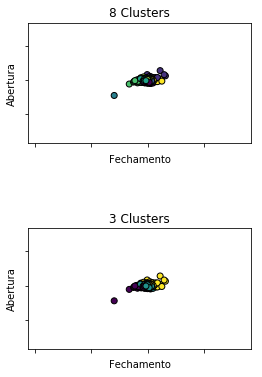

In [34]:
#outra comparação com o k-Means
#nesta comparação foi utilizadas configurações com 3 e 8 clusters
#a comparação é feita colocando os dois KMeans em um vetor
#os vetores são processados e adicionados à figura
#é impressa uma única figura com as duas configurações

estimators = [('k_means_8', KMeans(n_clusters=8)),
              ('k_means_3', KMeans(n_clusters=3))]

fignum = 0
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(4,6))
fig.subplots_adjust(hspace=0.7)
titles = ['8 Clusters', '3 Clusters']
for name, est in estimators:
    est.fit(X_train)
    labels = est.labels_

    #aqui são impressas na tela as medidas de desempenho obtidas para cada configuração (8 e 3 clusters)
    print('')
    print('Medidas Obtidas Usando o KMeans de %s e Todos os Componentes da Partição 1' % titles[fignum])
    print("Homogeneidade: %0.3f" % metrics.homogeneity_score(labels_true, labels))
    print("Completude: %0.3f" % metrics.completeness_score(labels_true, labels))
    print("V-medida: %0.3f" % metrics.v_measure_score(labels_true, labels))
    print("Índice Rand Ajustado: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
    print("Informação Mútua Ajustada: %0.3f" % metrics.adjusted_mutual_info_score(labels_true, labels))
    print("Informação Mútua Normalizada: %0.3f" % metrics.normalized_mutual_info_score(labels_true, labels))
    print("Informação Mútua: %0.3f" % metrics.mutual_info_score(labels_true, labels))
    print("Índice Fowlkes-Mallows: %0.3f" % metrics.fowlkes_mallows_score(labels_true, labels)) 
    print("Coeficiente Calinski-Harabaz: %0.3f" % metrics.calinski_harabaz_score(X_train, labels))
    print("Coeficiente Silhueta: %0.3f" % metrics.silhouette_score(X_train, labels))

    #aqui, as mesmas medidas de desempenho obtidas para cada configuração são usadas
    #aqui, essas medidas são gravadas em um arquivo texto
    arquivo.write('\n')
    arquivo.write('Medidas Obtidas Usando o KMeans de %s e Todos os Componentes da Partição 1\n' % titles[fignum])
    arquivo.write("Homogeneidade: %0.3f\n" % metrics.homogeneity_score(labels_true, labels))
    arquivo.write("Completude: %0.3f\n" % metrics.completeness_score(labels_true, labels))
    arquivo.write("V-medida: %0.3f\n" % metrics.v_measure_score(labels_true, labels))
    arquivo.write("Índice Rand Ajustado: %0.3f\n" % metrics.adjusted_rand_score(labels_true, labels))
    arquivo.write("Informação Mútua Ajustada: %0.3f\n" % metrics.adjusted_mutual_info_score(labels_true, labels))
    arquivo.write("Informação Mútua Normalizada: %0.3f\n" % metrics.normalized_mutual_info_score(labels_true, labels))
    arquivo.write("Informação Mútua: %0.3f\n" % metrics.mutual_info_score(labels_true, labels))
    arquivo.write("Índice Fowlkes-Mallows: %0.3f\n" % metrics.fowlkes_mallows_score(labels_true, labels)) 
    arquivo.write("Coeficiente Calinski-Harabaz: %0.3f\n" % metrics.calinski_harabaz_score(X_train, labels))
    arquivo.write("Coeficiente Silhueta: %0.3f\n" % metrics.silhouette_score(X_train, labels))

    #um mesmo gráfico com as duas configurações é criado e plotado
    axs[fignum].scatter(X_train[:, 3], X_train[:, 0],
                  c=labels.astype(np.float), edgecolor='k')
    axs[fignum].set_xticklabels([])
    axs[fignum].set_yticklabels([])
    axs[fignum].set_xlabel('Fechamento')
    axs[fignum].set_ylabel('Abertura')
    axs[fignum].set_title(titles[fignum])

    fignum = fignum + 1
plt.show()


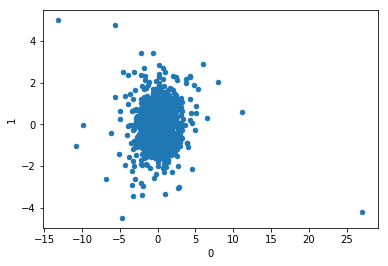

In [35]:
#para tentar diminuir a sobreposição dos clusters, foi utilizada a decomposição PCA em 2 componentes
x = StandardScaler().fit_transform(X_train)
pca = PCA(n_components=2)
principalComponents = pd.DataFrame(pca.fit_transform(x))

#aqui, os componentes principais são mostrados em um gráfico ScatterPlot
principalComponents.plot.scatter(x=0,y=1)
plt.show()

df_class = pd.DataFrame(y_train)
principalComponents_train = pd.concat([principalComponents,df_class],axis=1)

In [36]:
#aqui é executado o algoritmo de agrupamento baseado em densidade DBSCAN para os 2 componentes principais
#o valor eps=0.17 obteve o melhor resultado conforme visualização gráfica

labels_true = np.array(y_train)

db = DBSCAN(eps=0.17, min_samples=10).fit(principalComponents)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)



Medidas Obtidas Usando o DBSCAN, os Dados da Partição 1, e os Dois Componentes Principais
Número estimado de grupos: 3
Número estimado de outliers: 497
Homogeneidade: 1.000
Completude: -0.000
V-medida: -0.000
Índice Rand Ajustado: 0.000
Informação Mútua Ajustada: -0.000
Informação Mútua Normalizada: -0.000
Informação Mútua: -0.000
Índice Fowlkes-Mallows: 0.732
Coeficiente Calinski-Harabaz: 5.502
Coeficiente Silhueta: 0.011


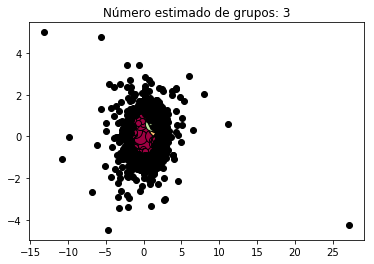

In [37]:
#abaixo estão algumas medidas obtidas do DBSCAN com os dois componentes principais
#foram utilizadas as mesmas medidas das bases anteriores
#esta é a parte que imprime as medidas na tela

print('')
print('Medidas Obtidas Usando o DBSCAN, os Dados da Partição 1, e os Dois Componentes Principais')
print('Número estimado de grupos: %d' % n_clusters_)
print('Número estimado de outliers: %d' % n_noise_)
print("Homogeneidade: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completude: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-medida: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Índice Rand Ajustado: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print("Informação Mútua Ajustada: %0.3f" % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Informação Mútua Normalizada: %0.3f" % metrics.normalized_mutual_info_score(labels_true, labels))
print("Informação Mútua: %0.3f" % metrics.mutual_info_score(labels_true, labels))
print("Índice Fowlkes-Mallows: %0.3f" % metrics.fowlkes_mallows_score(labels_true, labels))
print("Coeficiente Calinski-Harabaz: %0.3f" % metrics.calinski_harabaz_score(principalComponents, labels))
print("Coeficiente Silhueta: %0.3f" % metrics.silhouette_score(principalComponents, labels))

#esta é a parte onde as medidas são gravadas em um arquivo texto
arquivo.write('\n')
arquivo.write('Medidas Obtidas Usando o DBSCAN, os Dados da Partição 1, e os Dois Componentes Principais\n')
arquivo.write('Número estimado de grupos: %d\n' % n_clusters_)
arquivo.write('Número estimado de outliers: %d\n' % n_noise_)
arquivo.write("Homogeneidade: %0.3f\n" % metrics.homogeneity_score(labels_true, labels))
arquivo.write("Completude: %0.3f\n" % metrics.completeness_score(labels_true, labels))
arquivo.write("V-medida: %0.3f\n" % metrics.v_measure_score(labels_true, labels))
arquivo.write("Índice Rand Ajustado: %0.3f\n" % metrics.adjusted_rand_score(labels_true, labels))
arquivo.write("Informação Mútua Ajustada: %0.3f\n" % metrics.adjusted_mutual_info_score(labels_true, labels))
arquivo.write("Informação Mútua Normalizada: %0.3f\n" % metrics.normalized_mutual_info_score(labels_true, labels))
arquivo.write("Informação Mútua: %0.3f\n" % metrics.mutual_info_score(labels_true, labels))
arquivo.write("Índice Fowlkes-Mallows: %0.3f\n" % metrics.fowlkes_mallows_score(labels_true, labels))
arquivo.write("Coeficiente Calinski-Harabaz: %0.3f\n" % metrics.calinski_harabaz_score(principalComponents, labels))
arquivo.write("Coeficiente Silhueta: %0.3f\n" % metrics.silhouette_score(principalComponents, labels))

#esta parte gera e mostra o gráfico dos grupos obtidos com o DBSCAN e os dois componentes principais

unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = principalComponents_train[class_member_mask & core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = principalComponents_train[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Número estimado de grupos: %d' % n_clusters_)
plt.show()


Medidas Obtidas Usando o KMeans de 5 Clusters, os Dados da Partição 1, e os Dois Componentes Principais
Homogeneidade: 1.000
Completude: -0.000
V-medida: -0.000
Índice Rand Ajustado: 0.000
Informação Mútua Ajustada: -0.000
Informação Mútua Normalizada: -0.000
Informação Mútua: -0.000
Índice Fowlkes-Mallows: 0.732
Coeficiente Calinski-Harabaz: 5.502
Coeficiente Silhueta: 0.011


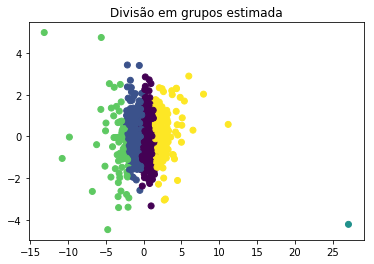

In [38]:
#esta parte é uma comparação com o k-Means de 5 clusters
#foi utilizada a partição 1 com os dois componentes principais

kmeans = KMeans(n_clusters=5, random_state=0).fit_predict(principalComponents)

#aqui foram utilizadas as mesmas medidas de desempenho de agrupamento dos algoritmos anteriores
#está é a parte que imprime os resultados na tela
print('')
print('Medidas Obtidas Usando o KMeans de 5 Clusters, os Dados da Partição 1, e os Dois Componentes Principais')
print("Homogeneidade: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completude: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-medida: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Índice Rand Ajustado: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print("Informação Mútua Ajustada: %0.3f" % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Informação Mútua Normalizada: %0.3f" % metrics.normalized_mutual_info_score(labels_true, labels))
print("Informação Mútua: %0.3f" % metrics.mutual_info_score(labels_true, labels))
print("Índice Fowlkes-Mallows: %0.3f" % metrics.fowlkes_mallows_score(labels_true, labels))
print("Coeficiente Calinski-Harabaz: %0.3f" % metrics.calinski_harabaz_score(principalComponents, labels))
print("Coeficiente Silhueta: %0.3f" % metrics.silhouette_score(principalComponents, labels))

#e esta é a parte que salva os resultados em um arquivo texto
arquivo.write('\n')
arquivo.write('Medidas Obtidas Usando o KMeans de 5 Clusters, os Dados da Partição 1, e os Dois Componentes Principais\n')
arquivo.write("Homogeneidade: %0.3f\n" % metrics.homogeneity_score(labels_true, labels))
arquivo.write("Completude: %0.3f\n" % metrics.completeness_score(labels_true, labels))
arquivo.write("V-medida: %0.3f\n" % metrics.v_measure_score(labels_true, labels))
arquivo.write("Índice Rand Ajustado: %0.3f\n" % metrics.adjusted_rand_score(labels_true, labels))
arquivo.write("Informação Mútua Ajustada: %0.3f\n" % metrics.adjusted_mutual_info_score(labels_true, labels))
arquivo.write("Informação Mútua Normalizada: %0.3f\n" % metrics.normalized_mutual_info_score(labels_true, labels))
arquivo.write("Informação Mútua: %0.3f\n" % metrics.mutual_info_score(labels_true, labels))
arquivo.write("Índice Fowlkes-Mallows: %0.3f\n" % metrics.fowlkes_mallows_score(labels_true, labels))
arquivo.write("Coeficiente Calinski-Harabaz: %0.3f\n" % metrics.calinski_harabaz_score(principalComponents, labels))
arquivo.write("Coeficiente Silhueta: %0.3f\n" % metrics.silhouette_score(principalComponents, labels))

#aqui, o gráfico do KMeans com 5 Clusters, Partição 1 e Dois Componentes Principais é Mostrado
plt.scatter(principalComponents_train.iloc[:, 0], principalComponents_train.iloc[:, 1], c=kmeans)
plt.title("Divisão em grupos estimada")
plt.show()



Medidas Obtidas Usando o KMeans de 8 Clusters, os Dados da Partição 1, e os Dois Componentes Principais
Homogeneidade: 1.000
Completude: 0.000
V-medida: 0.000
Índice Rand Ajustado: 0.000
Informação Mútua Ajustada: 0.000
Informação Mútua Normalizada: 0.000
Informação Mútua: 0.000
Índice Fowlkes-Mallows: 0.486
Coeficiente Calinski-Harabaz: 713.993
Coeficiente Silhueta: 0.317

Medidas Obtidas Usando o KMeans de 3 Clusters, os Dados da Partição 1, e os Dois Componentes Principais
Homogeneidade: 1.000
Completude: 0.000
V-medida: 0.000
Índice Rand Ajustado: 0.000
Informação Mútua Ajustada: 0.000
Informação Mútua Normalizada: 0.000
Informação Mútua: 0.000
Índice Fowlkes-Mallows: 0.713
Coeficiente Calinski-Harabaz: 633.204
Coeficiente Silhueta: 0.391


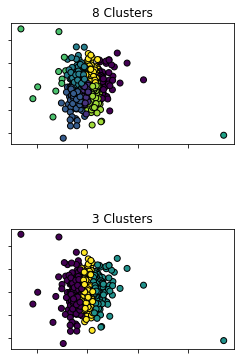

In [39]:
#outra comparação com o k-Means, a Partição 1 e os Dois Componentes Principais
#nesta comparação foi utilizadas configurações com 3 e 8 clusters

estimators = [('k_means_8', KMeans(n_clusters=8)),
              ('k_means_3', KMeans(n_clusters=3))]

fignum = 0
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(4,6))
fig.subplots_adjust(hspace=0.7)
titles = ['8 Clusters', '3 Clusters']
for name, est in estimators:
    est.fit(principalComponents)
    labels = est.labels_

    #aqui são impressas na tela as medidas de desempenho para cada configuração (8 e 3 clusters)
    print('')
    print('Medidas Obtidas Usando o KMeans de %s, os Dados da Partição 1, e os Dois Componentes Principais' % titles[fignum]	)
    print("Homogeneidade: %0.3f" % metrics.homogeneity_score(labels_true, labels))
    print("Completude: %0.3f" % metrics.completeness_score(labels_true, labels))
    print("V-medida: %0.3f" % metrics.v_measure_score(labels_true, labels))
    print("Índice Rand Ajustado: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
    print("Informação Mútua Ajustada: %0.3f" % metrics.adjusted_mutual_info_score(labels_true, labels))
    print("Informação Mútua Normalizada: %0.3f" % metrics.normalized_mutual_info_score(labels_true, labels))
    print("Informação Mútua: %0.3f" % metrics.mutual_info_score(labels_true, labels))
    print("Índice Fowlkes-Mallows: %0.3f" % metrics.fowlkes_mallows_score(labels_true, labels))
    print("Coeficiente Calinski-Harabaz: %0.3f" % metrics.calinski_harabaz_score(principalComponents, labels))
    print("Coeficiente Silhueta: %0.3f" % metrics.silhouette_score(principalComponents, labels))

    #as mesmas medidas de desempenho são gravadas em um arquivo texto
    arquivo.write('\n')
    arquivo.write('Medidas Obtidas Usando o KMeans de %s, os Dados da Partição 1, e os Dois Componentes Principais\n' % titles[fignum]	)
    arquivo.write("Homogeneidade: %0.3f\n" % metrics.homogeneity_score(labels_true, labels))
    arquivo.write("Completude: %0.3f\n" % metrics.completeness_score(labels_true, labels))
    arquivo.write("V-medida: %0.3f\n" % metrics.v_measure_score(labels_true, labels))
    arquivo.write("Índice Rand Ajustado: %0.3f\n" % metrics.adjusted_rand_score(labels_true, labels))
    arquivo.write("Informação Mútua Ajustada: %0.3f\n" % metrics.adjusted_mutual_info_score(labels_true, labels))
    arquivo.write("Informação Mútua Normalizada: %0.3f\n" % metrics.normalized_mutual_info_score(labels_true, labels))
    arquivo.write("Informação Mútua: %0.3f\n" % metrics.mutual_info_score(labels_true, labels))
    arquivo.write("Índice Fowlkes-Mallows: %0.3f\n" % metrics.fowlkes_mallows_score(labels_true, labels))
    arquivo.write("Coeficiente Calinski-Harabaz: %0.3f\n" % metrics.calinski_harabaz_score(principalComponents, labels))
    arquivo.write("Coeficiente Silhueta: %0.3f\n" % metrics.silhouette_score(principalComponents, labels))

    #um mesmo gráfico com as duas configurações é criado e plotado
    axs[fignum].scatter(principalComponents_train.iloc[:, 0], principalComponents_train.iloc[:, 1],
                  c=labels.astype(np.float), edgecolor='k')
    axs[fignum].set_xticklabels([])
    axs[fignum].set_yticklabels([])
    axs[fignum].set_title(titles[fignum])

    fignum = fignum + 1
plt.show()


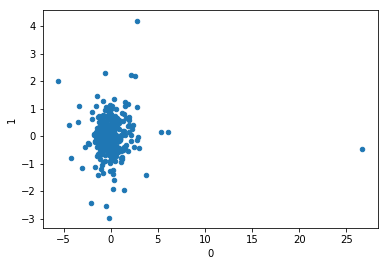

In [40]:
#aqui é usada a decomposição da partição 2 em dois componentes principais
x = StandardScaler().fit_transform(X_test)
pca = PCA(n_components=2)
principalComponents = pd.DataFrame(pca.fit_transform(x))

principalComponents.plot.scatter(x=0,y=1)
plt.show()

df_class = pd.DataFrame(y_test)
principalComponents_test = pd.concat([principalComponents,df_class],axis=1)


In [41]:
#aqui é executado o algoritmo de agrupamento baseado em densidade DBSCAN
#usando a Partição 2 e os Dois Componentes Principais
#o valor eps=0.20 obteve o melhor resultado conforme visualização gráfica
labels_true = np.array(y_test)

db = DBSCAN(eps=0.20, min_samples=10).fit(principalComponents)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)


Medidas Obtidas Usando o DBSCAN, os Dados da Partição 2, e os Dois Componentes Principais
Número estimado de grupos: 1
Número estimado de outliers: 169
Homogeneidade: 1.000
Completude: 0.000
V-medida: 0.000
Índice Rand Ajustado: 0.000
Informação Mútua Ajustada: 0.000
Informação Mútua Normalizada: 0.000
Informação Mútua: 0.000
Índice Fowlkes-Mallows: 0.710
Coeficiente Calinski-Harabaz: 4.410


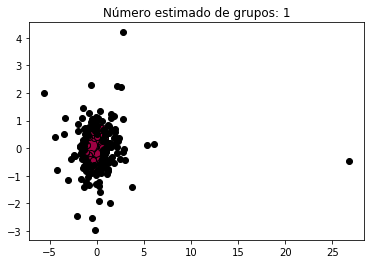

In [42]:
#abaixo são impressas na tela algumas medidas obtidas do DBSCAN usando a Partição 2 e os Dois Componentes Principais
print('')
print('Medidas Obtidas Usando o DBSCAN, os Dados da Partição 2, e os Dois Componentes Principais')
print('Número estimado de grupos: %d' % n_clusters_)
print('Número estimado de outliers: %d' % n_noise_)
print("Homogeneidade: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completude: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-medida: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Índice Rand Ajustado: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print("Informação Mútua Ajustada: %0.3f" % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Informação Mútua Normalizada: %0.3f" % metrics.normalized_mutual_info_score(labels_true, labels))
print("Informação Mútua: %0.3f" % metrics.mutual_info_score(labels_true, labels))
print("Índice Fowlkes-Mallows: %0.3f" % metrics.fowlkes_mallows_score(labels_true, labels))
print("Coeficiente Calinski-Harabaz: %0.3f" % metrics.calinski_harabaz_score(principalComponents, labels))
#print("Coeficiente Silhueta: %0.3f" % metrics.silhouette_score(principalComponents, labels))
#print("Coeficiente Silhueta Para Cada Amostra: %0.3f" % metrics.silhouette_samples(principalComponents, labels))

#aqui são as mesmas medidas, porém gravadas em um arquivo texto
arquivo.write('\n')
arquivo.write('Medidas Obtidas Usando o DBSCAN, os Dados da Partição 2, e os Dois Componentes Principais\n')
arquivo.write('Número estimado de grupos: %d\n' % n_clusters_)
arquivo.write('Número estimado de outliers: %d\n' % n_noise_)
arquivo.write("Homogeneidade: %0.3f\n" % metrics.homogeneity_score(labels_true, labels))
arquivo.write("Completude: %0.3f\n" % metrics.completeness_score(labels_true, labels))
arquivo.write("V-medida: %0.3f\n" % metrics.v_measure_score(labels_true, labels))
arquivo.write("Índice Rand Ajustado: %0.3f\n" % metrics.adjusted_rand_score(labels_true, labels))
arquivo.write("Informação Mútua Ajustada: %0.3f\n" % metrics.adjusted_mutual_info_score(labels_true, labels))
arquivo.write("Informação Mútua Normalizada: %0.3f\n" % metrics.normalized_mutual_info_score(labels_true, labels))
arquivo.write("Informação Mútua: %0.3f\n" % metrics.mutual_info_score(labels_true, labels))
arquivo.write("Índice Fowlkes-Mallows: %0.3f\n" % metrics.fowlkes_mallows_score(labels_true, labels))
arquivo.write("Coeficiente Calinski-Harabaz: %0.3f\n" % metrics.calinski_harabaz_score(principalComponents, labels))

#esta parte gera e mostra o gráfico dos grupos obtidos com o DBSCAN, Partição 2 e Dois Componentes Principais
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = principalComponents_test[class_member_mask & core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = principalComponents_test[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Número estimado de grupos: %d' % n_clusters_)
plt.show()


Medidas Obtidas Usando o KMeans de 5 Clusters, os Dados da Partição 2, e os Dois Componentes Principais
Homogeneidade: 1.000
Completude: 0.000
V-medida: 0.000
Índice Rand Ajustado: 0.000
Informação Mútua Ajustada: 0.000
Informação Mútua Normalizada: 0.000
Informação Mútua: 0.000
Índice Fowlkes-Mallows: 0.710
Coeficiente Calinski-Harabaz: 4.410


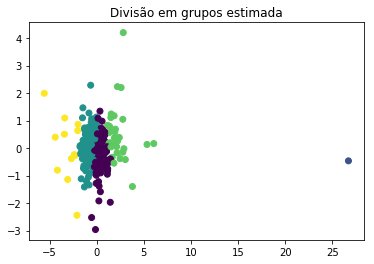

In [43]:
#esta parte é uma comparação com o k-Means, utilizando 5 Clusters, Partição 2 e Dois Componentes Principais
kmeans = KMeans(n_clusters=5, random_state=0).fit_predict(principalComponents)

#nesta parte, as medidas de desempenho do algoritmo são impressas na tela
print('')
print('Medidas Obtidas Usando o KMeans de 5 Clusters, os Dados da Partição 2, e os Dois Componentes Principais')
print("Homogeneidade: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completude: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-medida: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Índice Rand Ajustado: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print("Informação Mútua Ajustada: %0.3f" % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Informação Mútua Normalizada: %0.3f" % metrics.normalized_mutual_info_score(labels_true, labels))
print("Informação Mútua: %0.3f" % metrics.mutual_info_score(labels_true, labels))
print("Índice Fowlkes-Mallows: %0.3f" % metrics.fowlkes_mallows_score(labels_true, labels))
print("Coeficiente Calinski-Harabaz: %0.3f" % metrics.calinski_harabaz_score(principalComponents, labels))
#print("Coeficiente Silhueta: %0.3f" % metrics.silhouette_score(principalComponents, labels))
#print("Coeficiente Silhueta Para Cada Amostra: %0.3f" % metrics.silhouette_samples(principalComponents, labels))

#aqui, as mesmas medidas de desempenho são gravadas em um arquivo texto
arquivo.write('\n')
arquivo.write('Medidas Obtidas Usando o KMeans de 5 Clusters, os Dados da Partição 2, e os Dois Componentes Principais\n')
arquivo.write("Homogeneidade: %0.3f\n" % metrics.homogeneity_score(labels_true, labels))
arquivo.write("Completude: %0.3f\n" % metrics.completeness_score(labels_true, labels))
arquivo.write("V-medida: %0.3f\n" % metrics.v_measure_score(labels_true, labels))
arquivo.write("Índice Rand Ajustado: %0.3f\n" % metrics.adjusted_rand_score(labels_true, labels))
arquivo.write("Informação Mútua Ajustada: %0.3f\n" % metrics.adjusted_mutual_info_score(labels_true, labels))
arquivo.write("Informação Mútua Normalizada: %0.3f\n" % metrics.normalized_mutual_info_score(labels_true, labels))
arquivo.write("Informação Mútua: %0.3f\n" % metrics.mutual_info_score(labels_true, labels))
arquivo.write("Índice Fowlkes-Mallows: %0.3f\n" % metrics.fowlkes_mallows_score(labels_true, labels))
arquivo.write("Coeficiente Calinski-Harabaz: %0.3f\n" % metrics.calinski_harabaz_score(principalComponents, labels))
#arquivo.write("Coeficiente Silhueta: %0.3f\n" % metrics.silhouette_score(principalComponents, labels))
#arquivo.write("Coeficiente Silhueta Para Cada Amostra: %0.3f\n" % metrics.silhouette_samples(principalComponents, labels))

#esta parte plota um gráfico com o KMeans de 5 clusters, a partição 2 e os dois componentes principais
plt.scatter(principalComponents_test.iloc[:, 0], principalComponents_test.iloc[:, 1], c=kmeans)
plt.title("Divisão em grupos estimada")
plt.show()



Medidas Obtidas Usando o KMeans de 8 Clusters, os Dados da Partição 2, e os Dois Componentes Principais
Homogeneidade: 1.000
Completude: -0.000
V-medida: -0.000
Índice Rand Ajustado: 0.000
Informação Mútua Ajustada: -0.000
Informação Mútua Normalizada: -0.000
Informação Mútua: -0.000
Índice Fowlkes-Mallows: 0.476
Coeficiente Calinski-Harabaz: 395.916

Medidas Obtidas Usando o KMeans de 3 Clusters, os Dados da Partição 2, e os Dois Componentes Principais
Homogeneidade: 1.000
Completude: -0.000
V-medida: -0.000
Índice Rand Ajustado: 0.000
Informação Mútua Ajustada: -0.000
Informação Mútua Normalizada: -0.000
Informação Mútua: -0.000
Índice Fowlkes-Mallows: 0.744
Coeficiente Calinski-Harabaz: 410.834


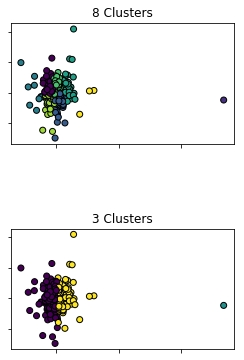

In [44]:
#outra comparação com o k-Means, partição 2 e os dois componentes principais
#nesta comparação foi utilizadas configurações com 3 e 8 clusters

estimators = [('k_means_8', KMeans(n_clusters=8)),
              ('k_means_3', KMeans(n_clusters=3))]

fignum = 0
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(4,6))
fig.subplots_adjust(hspace=0.7)
titles = ['8 Clusters', '3 Clusters']
for name, est in estimators:
    est.fit(principalComponents)
    labels = est.labels_

    #aqui são impressas na tela as medidas de desempenho para cada configuração (8 e 3 clusters)
    print('')
    print('Medidas Obtidas Usando o KMeans de %s, os Dados da Partição 2, e os Dois Componentes Principais' % titles[fignum])
    print("Homogeneidade: %0.3f" % metrics.homogeneity_score(labels_true, labels))
    print("Completude: %0.3f" % metrics.completeness_score(labels_true, labels))
    print("V-medida: %0.3f" % metrics.v_measure_score(labels_true, labels))
    print("Índice Rand Ajustado: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
    print("Informação Mútua Ajustada: %0.3f" % metrics.adjusted_mutual_info_score(labels_true, labels))
    print("Informação Mútua Normalizada: %0.3f" % metrics.normalized_mutual_info_score(labels_true, labels))
    print("Informação Mútua: %0.3f" % metrics.mutual_info_score(labels_true, labels))
    print("Índice Fowlkes-Mallows: %0.3f" % metrics.fowlkes_mallows_score(labels_true, labels))
    print("Coeficiente Calinski-Harabaz: %0.3f" % metrics.calinski_harabaz_score(principalComponents, labels))
   #print("Coeficiente Silhueta: %0.3f" % metrics.silhouette_score(principalComponents, labels))
   #print("Coeficiente Silhueta Para Cada Amostra: %0.3f" % metrics.silhouette_samples(principalComponents, labels))

    #as mesmas medidas de desempenho são gravadas em um arquivo texto
    arquivo.write('\n')
    arquivo.write('Medidas Obtidas Usando o KMeans de %s, os Dados da Partição 2, e os Dois Componentes Principais\n' % titles[fignum])
    arquivo.write("Homogeneidade: %0.3f\n" % metrics.homogeneity_score(labels_true, labels))
    arquivo.write("Completude: %0.3f\n" % metrics.completeness_score(labels_true, labels))
    arquivo.write("V-medida: %0.3f\n" % metrics.v_measure_score(labels_true, labels))
    arquivo.write("Índice Rand Ajustado: %0.3f\n" % metrics.adjusted_rand_score(labels_true, labels))
    arquivo.write("Informação Mútua Ajustada: %0.3f\n" % metrics.adjusted_mutual_info_score(labels_true, labels))
    arquivo.write("Informação Mútua Normalizada: %0.3f\n" % metrics.normalized_mutual_info_score(labels_true, labels))
    arquivo.write("Informação Mútua: %0.3f\n" % metrics.mutual_info_score(labels_true, labels))
    arquivo.write("Índice Fowlkes-Mallows: %0.3f\n" % metrics.fowlkes_mallows_score(labels_true, labels))
    arquivo.write("Coeficiente Calinski-Harabaz: %0.3f\n" % metrics.calinski_harabaz_score(principalComponents, labels))

    #um mesmo gráfico com as duas medidas é criado e plotado
    axs[fignum].scatter(principalComponents_test.iloc[:, 0], principalComponents_test.iloc[:, 1],
                  c=labels.astype(np.float), edgecolor='k')
    axs[fignum].set_xticklabels([])
    axs[fignum].set_yticklabels([])
    axs[fignum].set_title(titles[fignum])

    fignum = fignum + 1
plt.show()

#o arquivo texto é fechado e salvo no disco
arquivo.close()